In [1]:
import os
import skimage.data

def load_data(data_dir):
    directories = [d for d in os.listdir(data_dir)
                  if os.path.isdir(os.path.join(data_dir, d))]
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f)
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

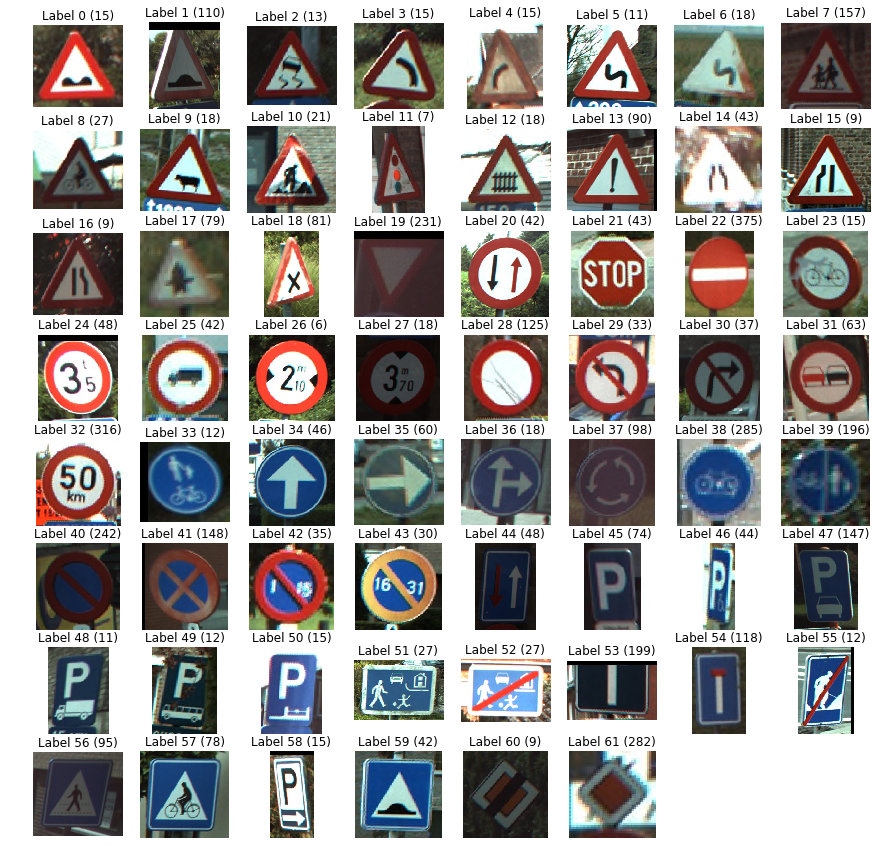

In [2]:
import matplotlib
import matplotlib.pyplot as plt

def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

data_dir = 'Training'    
[images,labels]=load_data(data_dir)
display_images_and_labels(images, labels)

In [3]:
for image in images[:62]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (57, 57, 3), min: 28, max: 255
shape: (54, 43, 3), min: 5, max: 255
shape: (121, 128, 3), min: 0, max: 217
shape: (68, 55, 3), min: 19, max: 255
shape: (68, 57, 3), min: 16, max: 255
shape: (58, 60, 3), min: 4, max: 255
shape: (52, 55, 3), min: 14, max: 255
shape: (195, 216, 3), min: 13, max: 255
shape: (84, 85, 3), min: 7, max: 202
shape: (87, 97, 3), min: 28, max: 255
shape: (108, 68, 3), min: 12, max: 249
shape: (322, 347, 3), min: 0, max: 255
shape: (62, 64, 3), min: 15, max: 254
shape: (81, 91, 3), min: 3, max: 250
shape: (87, 88, 3), min: 11, max: 203
shape: (55, 55, 3), min: 25, max: 255
shape: (121, 129, 3), min: 20, max: 255
shape: (128, 141, 3), min: 10, max: 255
shape: (75, 43, 3), min: 0, max: 255
shape: (54, 55, 3), min: 18, max: 255
shape: (110, 119, 3), min: 0, max: 233
shape: (123, 135, 3), min: 12, max: 255
shape: (64, 71, 3), min: 4, max: 249
shape: (64, 55, 3), min: 15, max: 255
shape: (159, 169, 3), min: 0, max: 255
shape: (110, 120, 3), min: 0, max: 255
shap

In [4]:
import skimage.transform
images64 = [skimage.transform.resize(image, (64,64)) for image in images]

/home/ro/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
import numpy as np
from keras.utils.np_utils import to_categorical

y = np.array(labels)
X = np.array(images64)
num_categories = 62
y = to_categorical(y, num_categories)

Using TensorFlow backend.


In [6]:
from keras.models import Model
from keras.layers import Dense, Flatten, Input, Dropout
from keras.layers import Convolution2D, MaxPooling2D
from sklearn.model_selection import train_test_split

inputs = Input(shape=(64,64,3))

x = Convolution2D(32, 4,4, border_mode='same', activation='relu')(inputs)
x = Convolution2D(32, 4,4, border_mode='same', activation='relu')(x)
x = Convolution2D(32, 4,4, border_mode='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

x = Convolution2D(64, 4, 4, border_mode='same', activation='relu')(x)
x = Convolution2D(64, 4, 4, border_mode='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.50)(x)

predictions = Dense(62, activation='softmax')(x)

model = Model(input=inputs, output=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3, stratify=y, )
model.fit(X_train, y_train, epochs=30, batch_size=50)

/home/ro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (4, 4), activation="relu", padding="same")`
  
/home/ro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (4, 4), activation="relu", padding="same")`
  if __name__ == '__main__':
/home/ro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (4, 4), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/home/ro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), activation="relu", padding="same")`
  from ipykernel import kernelapp as app
/home/ro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Kera

Epoch 1/30
3660/3660 [==============================] - 122s 33ms/step - loss: 3.5197 - acc: 0.1989
Epoch 2/30
3660/3660 [==============================] - 137s 37ms/step - loss: 1.5618 - acc: 0.6451
Epoch 3/30
3660/3660 [==============================] - 129s 35ms/step - loss: 0.6249 - acc: 0.8451
Epoch 4/30
3660/3660 [==============================] - 128s 35ms/step - loss: 0.3264 - acc: 0.9183
Epoch 5/30
3660/3660 [==============================] - 125s 34ms/step - loss: 0.2000 - acc: 0.9492
Epoch 6/30
3660/3660 [==============================] - 123s 34ms/step - loss: 0.2044 - acc: 0.9582
Epoch 7/30
3660/3660 [==============================] - 122s 33ms/step - loss: 0.1368 - acc: 0.9724
Epoch 8/30
3660/3660 [==============================] - 122s 33ms/step - loss: 0.0935 - acc: 0.9787
Epoch 9/30
3660/3660 [==============================] - 133s 36ms/step - loss: 0.1133 - acc: 0.9713
Epoch 10/30
3660/3660 [==============================] - 131s 36ms/step - loss: 0.0851 - acc: 0.9795